In [274]:
import os
from os.path import join
import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer

from sklearn.model_selection import validation_curve

# Raw Data

In [2]:
red_wine = os.path.join('data','wine', 'winequality-red.csv')
white_wine = os.path.join('data','wine', 'winequality-white.csv')
turbine = os.path.join('data','turbine','gt_2011.csv')
mushrooms = os.path.join('data','mushroom','secondary_data.csv')

# encoders to use
scale = StandardScaler()
ohe = OneHotEncoder(sparse_output=False)

In [3]:
transformer = make_column_transformer(
    (
        ohe, 
        [
        'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 
       'stem-root', 'stem-surface', 'stem-color','veil-type', 'veil-color',
        'has-ring', 'ring-type', 'spore-print-color','habitat', 'season'
        ]
        ),
    remainder='passthrough'
    )

# pre-process shroom data

shroom_df = pd.read_csv(mushrooms,sep=';').sample(frac=1).reset_index(drop=True)
x = shroom_df.iloc[:,1:].copy()
x_shroom = pd.DataFrame(transformer.fit_transform(x), 
                columns=transformer.get_feature_names_out())
y = shroom_df.iloc[:,0].copy()
y_shroom = (y == 'p')


# reduce the number of training examples
x_shroom = x_shroom[:7000]
y_shroom =  y_shroom[:7000]

# Scale numerical attributes to be b/w 1 and -1
lst_of_num_cols = [
    'remainder__cap-diameter', 'remainder__stem-height', 'remainder__stem-width'
    ]
x_shroom[lst_of_num_cols] = scale.fit_transform(x_shroom[lst_of_num_cols])

In [4]:
white_df = pd.read_csv(white_wine, sep=';')
red_df = pd.read_csv(red_wine, sep=';')
white_df['type'] = 0
red_df['type'] = 1
wine_df = pd.concat([white_df,red_df])
wine_df = wine_df.sample(frac=1).reset_index(drop=True)

# set x and y values
# remove 'quality' and 'type' column from x array
x_wine = wine_df.iloc[:,:-2].copy()
# scale x vals
x_wine.values[:,:] = scale.fit_transform(x_wine)
# set y array equal to 'type' column 
y_wine = wine_df.iloc[:,-1].copy()

In [5]:
DATA_FOLDER = join('algo_data') 

# Helper Functions

In [161]:
def plot_curve(x_data, y_mean, y_std, axs=None,
                take_mean=True, name='', x_name='num_clusters', label=''):

    axs.set_title(name, fontsize=20)
    axs.tick_params(axis='both', labelsize=20)
    axs.set_xlabel(x_name, fontsize=20)

    if axs == None:
        _, axs = plt.subplots()

    if take_mean:
        axs.plot(x_data,y_mean,'o-', label=label)
        line = axs.fill_between(x_data, y_mean + y_std, y_mean - y_std,alpha=0.3)
    else:
        line = axs.plot(x_data, y_mean)

    axs.legend(fontsize=15,bbox_to_anchor = (1.25, 0.6), loc='center')
    
    return line

In [7]:
def plot_bic_curve(x_data, y_mean, y_std, axs=None,
                    take_mean=True, name='', x_name='num_clusters',
                      selected_compoents=1):
    
    axs.set_title(name, fontsize=20)
    axs.tick_params(axis='both', labelsize=20)
    axs.set_xlabel(x_name, fontsize=20)

    if axs == None:
        _, axs = plt.subplots()

    if take_mean:
        line = axs.errorbar(x=x_data,y=y_mean, yerr=y_std, fmt='o')
    else:
        line = axs.scatter(x_data, y_mean)

    # axs.

    return line

In [8]:
def plot_rca_curve(x_data, y_mean, y_std=None, axs=None,
                take_mean=True, name='', x_name='num_components', 
                selected_components=1):
    
    axs.set_title(name,fontsize=20)
    axs.tick_params(axis='both', labelsize=20)
    axs.set_xlabel(x_name,fontsize=20)

    if axs == None:
        _, axs = plt.subplots()

    if take_mean:
        axs.plot(x_data,y_mean,'o-', label=name)
        line = axs.fill_between(x_data, y_mean + y_std, y_mean - y_std,alpha=0.3)
    else:
        line = axs.plot(x_data, y_mean, label=name)
    
    axs.axvline(selected_components, linestyle=':',
                c='orange', label=f'{selected_components} chosen\ncomponents',lw=3)
    axs.legend(fontsize=15)

    return line

In [9]:
def plot_dr_clust_curve(x_data, y_mean, y_std, axs=None,
                take_mean=True, name='', x_name='num_clusters',
                selected_components=1, label='KM'):
    axs.set_title(name, fontsize=20)
    axs.tick_params(axis='both', labelsize=20)
    axs.set_xlabel(x_name, fontsize=20)

    if axs == None:
        _, axs = plt.subplots()

    if take_mean:
        axs.plot(x_data,y_mean,'o-')
        line = axs.fill_between(x_data, y_mean + y_std, y_mean - y_std,alpha=0.3)
    else:
        line = axs.plot(x_data, y_mean)

    # axs.axvline(x=selected_components, color='orange',
    #                     linestyle=':', label=label, lw=3)

    return line

In [286]:
def plot_validation_curve(val_curve, x_range, param_name, model_name, axs=None,\
                          plot_train=True, plot_test=True):

    train, test = val_curve
    train_mean = train.mean(1)
    train_sd = train.std(1)
    test_mean = test.mean(1)
    test_sd = test.std(1)
    axs = axs
    x = x_range
    if plot_train:
        line, = axs.plot(x,train_mean, 'o-', label='train score')
        axs.fill_between(x,train_mean + train_sd, train_mean - train_sd,alpha=0.3)
    if plot_test:
        axs.plot(x,test_mean,'o-', label='test score')
        axs.fill_between(x, test_mean + test_sd, test_mean - test_sd,alpha=0.3)
    axs.set_title(f'{model_name} validation curve', fontsize = 15)
    axs.set_xlabel(f'{param_name}', fontsize = 15)
    axs.set_ylabel(f'f1 score', fontsize = 15)
    axs.legend(loc='lower right')
    axs.tick_params(axis='both', which='major', labelsize=15)
    axs.tick_params(axis='both', which='minor', labelsize=15)

    return line

# Read in Data

## Clustering Results

In [10]:
## read wine results
df_km_wine = pd.read_csv(join(DATA_FOLDER,'df_km_wine.csv'))
s_km_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_km_cluster_wine.csv'))
x_km_wine= pd.read_csv(join(DATA_FOLDER,'x_km_wine.csv'))

df_em_wine= pd.read_csv(join(DATA_FOLDER,'df_em_wine.csv'))
df_em_score_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_wine.csv'))
s_em_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_wine.csv'))
x_em_wine= pd.read_csv(join(DATA_FOLDER,'x_em_wine.csv'))

In [11]:
## read shroom results

df_km_shroom = pd.read_csv(join(DATA_FOLDER,'df_km_shroom.csv'))
s_km_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_km_cluster_shroom.csv'))
x_km_shroom= pd.read_csv(join(DATA_FOLDER,'x_km_shroom.csv'))

df_em_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_shroom.csv'))
df_em_score_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_score_shroom.csv'))
s_em_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_shroom.csv'))
x_em_shroom= pd.read_csv(join(DATA_FOLDER,'x_em_shroom.csv'))

## Dimension Reduction Results

In [12]:
# dimension reduced wine dataset
df_pca_wine= pd.read_csv(join(DATA_FOLDER,'df_pca_wine.csv'))
s_pca_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_pca_cluster_wine.csv'))
x_pca_wine= pd.read_csv(join(DATA_FOLDER,'x_pca_wine.csv'))

df_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_rca_wine.csv'))
s_rca_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_rca_cluster_wine.csv'))
x_rca_wine= pd.read_csv(join(DATA_FOLDER,'x_rca_wine.csv'))

df_man_wine= pd.read_csv(join(DATA_FOLDER,'df_man_wine.csv'))
s_man_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_man_cluster_wine.csv'))
x_man_wine= pd.read_csv(join(DATA_FOLDER,'x_man_wine.csv'))

df_ica_wine= pd.read_csv(join(DATA_FOLDER,'df_ica_wine.csv'))
s_ica_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_ica_cluster_wine.csv'))
x_ica_wine= pd.read_csv(join(DATA_FOLDER,'x_ica_wine.csv'))

In [13]:
# dimension reduced shroom dataset
df_pca_shroom= pd.read_csv(join(DATA_FOLDER,'df_pca_shroom.csv'))
s_pca_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_pca_cluster_shroom.csv'))
x_pca_shroom= pd.read_csv(join(DATA_FOLDER,'x_pca_shroom.csv'))

df_rca_shroom= pd.read_csv(join(DATA_FOLDER,'df_rca_shroom.csv'))
s_rca_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_rca_cluster_shroom.csv'))
x_rca_shroom= pd.read_csv(join(DATA_FOLDER,'x_rca_shroom.csv'))

df_man_shroom= pd.read_csv(join(DATA_FOLDER,'df_man_shroom.csv'))
s_man_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_man_cluster_shroom.csv'))
x_man_shroom= pd.read_csv(join(DATA_FOLDER,'x_man_shroom.csv'))

df_ica_shroom= pd.read_csv(join(DATA_FOLDER,'df_ica_shroom.csv'))
s_ica_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_ica_cluster_shroom.csv'))
x_ica_shroom= pd.read_csv(join(DATA_FOLDER,'x_ica_shroom.csv'))

## Clustering on DRed datasets

In [265]:
## read in clustering on dimension reduced wine set
df_km_pca_wine= pd.read_csv(join(DATA_FOLDER,'df_km_pca_wine.csv'))
s_km_pca_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_km_pca_cluster_wine.csv'))
x_km_pca_wine= pd.read_csv(join(DATA_FOLDER,'x_km_pca_wine.csv'))

df_em_pca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_pca_wine.csv'))
df_em_score_pca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_pca_wine.csv'))
s_em_cluster_pca_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_pca_wine.csv'))
x_em_pca_wine= pd.read_csv(join(DATA_FOLDER,'x_em_pca_wine.csv'))

df_km_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_km_rca_wine.csv'))
s_km_rca_cluster_wine= pd.read_csv(join(DATA_FOLDER,'df_km_rca_wine.csv'))
x_km_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_km_rca_wine.csv'))

df_em_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_rca_wine.csv'))
df_em_score_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_rca_wine.csv'))
s_em_cluster_rca_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_rca_wine.csv')) 
x_em_rca_wine= pd.read_csv(join(DATA_FOLDER,'x_em_rca_wine.csv'))

df_km_man_wine= pd.read_csv(join(DATA_FOLDER,'df_km_man_wine.csv'))
s_km_man_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_km_man_cluster_wine.csv'))
x_km_man_wine= pd.read_csv(join(DATA_FOLDER,'df_km_man_wine.csv'))

df_em_man_wine= pd.read_csv(join(DATA_FOLDER,'df_km_man_wine.csv'))
df_em_score_man_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_man_wine.csv'))
s_em_cluster_man_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_man_wine.csv'))
x_em_man_wine= pd.read_csv(join(DATA_FOLDER,'x_em_man_wine.csv'))

df_km_ica_wine= pd.read_csv(join(DATA_FOLDER,'df_km_ica_wine.csv'))
s_km_ica_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_km_ica_cluster_wine.csv'))
x_km_ica_wine= pd.read_csv(join(DATA_FOLDER,'df_km_ica_wine.csv'))

df_em_ica_wine= pd.read_csv(join(DATA_FOLDER,'df_km_ica_wine.csv'))
df_em_score_ica_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_ica_wine.csv'))
s_em_cluster_ica_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_ica_wine.csv'))
x_em_ica_wine= pd.read_csv(join(DATA_FOLDER,'x_em_ica_wine.csv'))

In [267]:
## read in clustering on dimension reduced wine set
df_km_pca_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_pca_shroom.csv'))
s_km_pca_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_km_pca_cluster_shroom.csv'))
x_km_pca_shroom= pd.read_csv(join(DATA_FOLDER,'x_km_pca_shroom.csv'))

df_em_pca_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_pca_shroom.csv'))
df_em_score_pca_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_score_pca_shroom.csv'))
s_em_cluster_pca_shroom= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_pca_shroom.csv'))
x_em_pca_shroom= pd.read_csv(join(DATA_FOLDER,'x_em_pca_shroom.csv'))

df_km_rca_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_rca_shroom.csv'))
s_km_rca_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_rca_shroom.csv'))
x_km_rca_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_rca_shroom.csv'))

df_em_rca_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_rca_shroom.csv'))
df_em_score_rca_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_score_rca_shroom.csv'))
s_em_cluster_rca_shroom= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_rca_shroom.csv')) 
x_em_rca_shroom= pd.read_csv(join(DATA_FOLDER,'x_em_rca_shroom.csv'))

df_km_man_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_man_shroom.csv'))
s_km_man_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_km_man_cluster_shroom.csv'))
x_km_man_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_man_shroom.csv'))

df_em_man_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_man_shroom.csv'))
df_em_score_man_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_score_man_shroom.csv'))
s_em_cluster_man_shroom= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_man_shroom.csv'))
x_em_man_shroom= pd.read_csv(join(DATA_FOLDER,'x_em_man_shroom.csv'))

df_km_ica_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_ica_shroom.csv'))
s_km_ica_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_km_ica_cluster_shroom.csv'))
x_km_ica_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_ica_shroom.csv'))

df_em_ica_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_ica_shroom.csv'))
df_em_score_ica_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_score_ica_shroom.csv'))
s_em_cluster_ica_shroom= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_ica_shroom.csv'))
x_em_ica_shroom= pd.read_csv(join(DATA_FOLDER,'x_em_ica_shroom.csv'))

# Visualizations

## Clustering on Raw Data

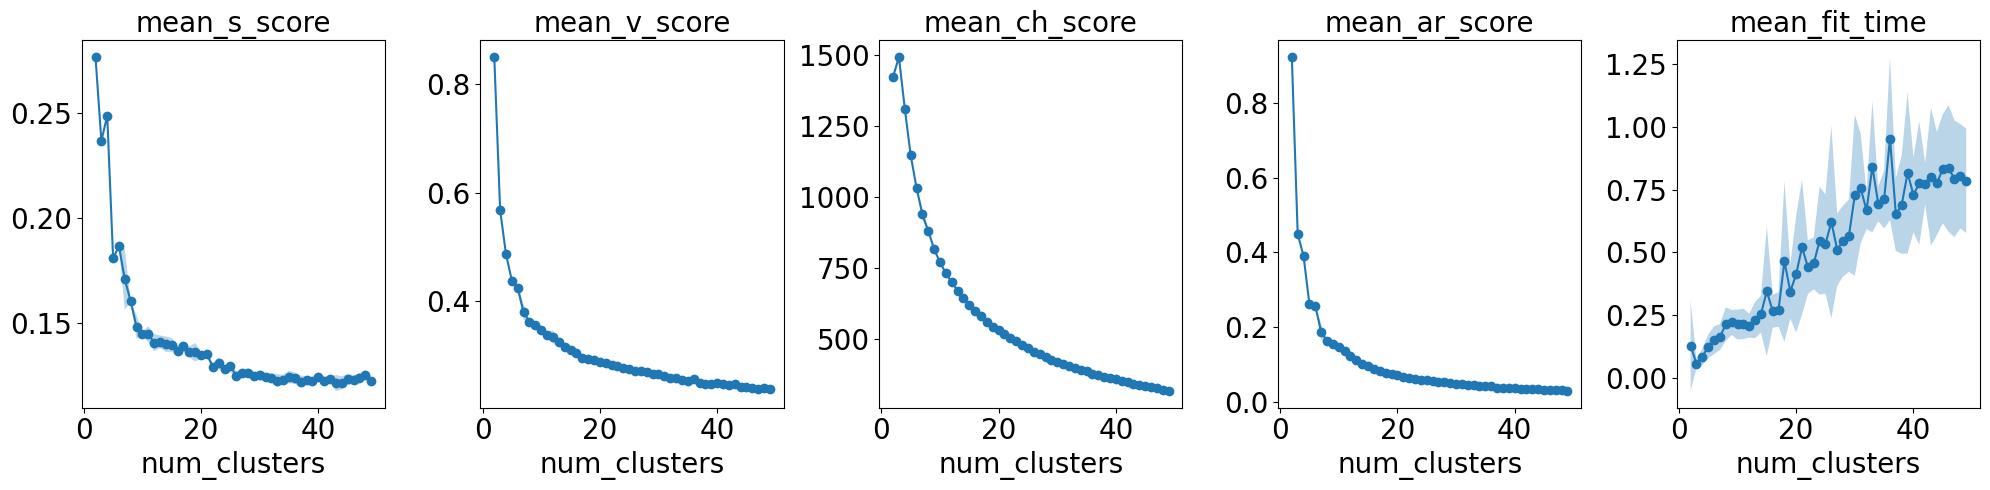

In [17]:
## K Means Clustering Results
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'
    y_mean = df_km_wine[col_name]
    y_std = df_km_wine[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    count=count+1

y_mean = df_km_wine['mean_fit_time']
y_std = df_km_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
plt.tight_layout()
plt.show()

In [18]:
df_em_score_wine.columns.unique()

Index(['Unnamed: 0', 'num_clusters', 'mean_fit_time', 'std_fit_time',
       'mean_s_score', 'std_s_score', 'mean_v_score', 'std_v_score',
       'mean_ch_score', 'std_ch_score', 'mean_ar_score', 'std_ar_score'],
      dtype='object')

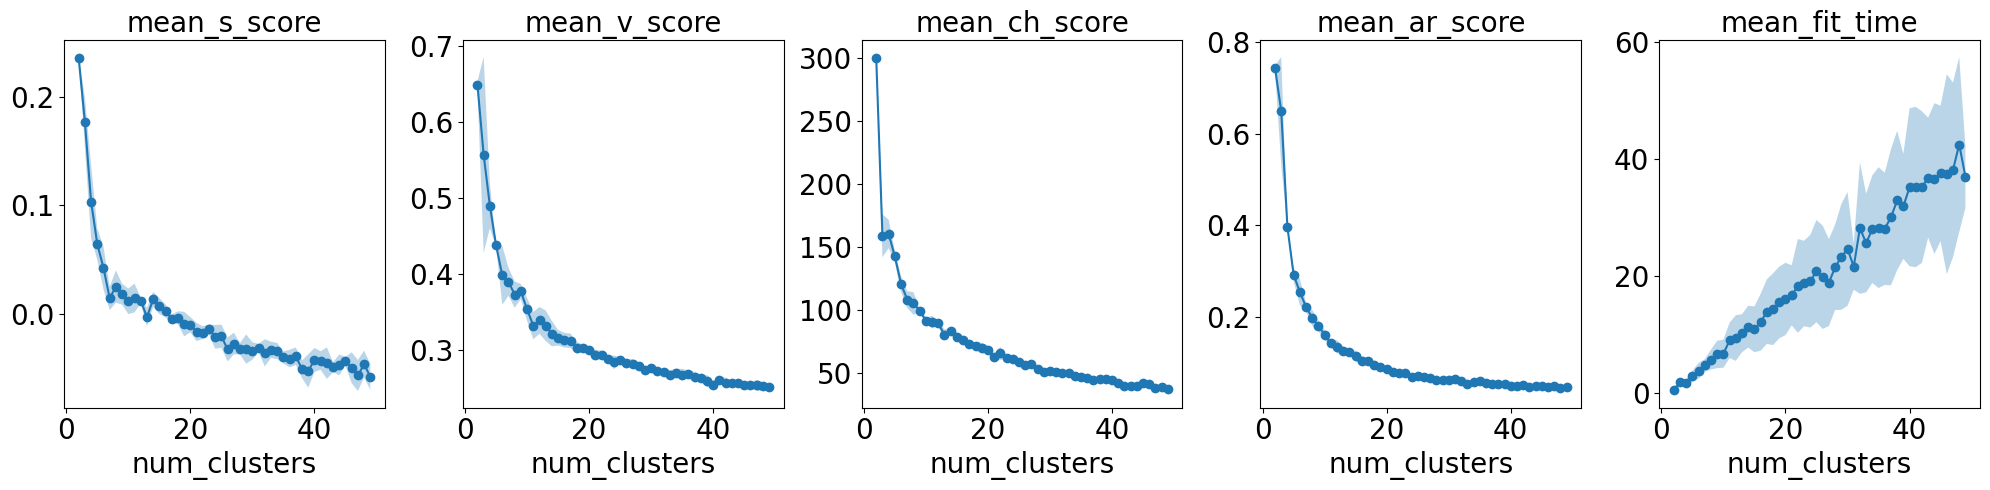

In [19]:
## EM Clustering Results
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_em_score_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'
    y_mean = df_em_score_wine[col_name]
    y_std = df_em_score_wine[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    count=count+1

y_mean = df_em_score_wine['mean_fit_time']
y_std = df_em_score_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


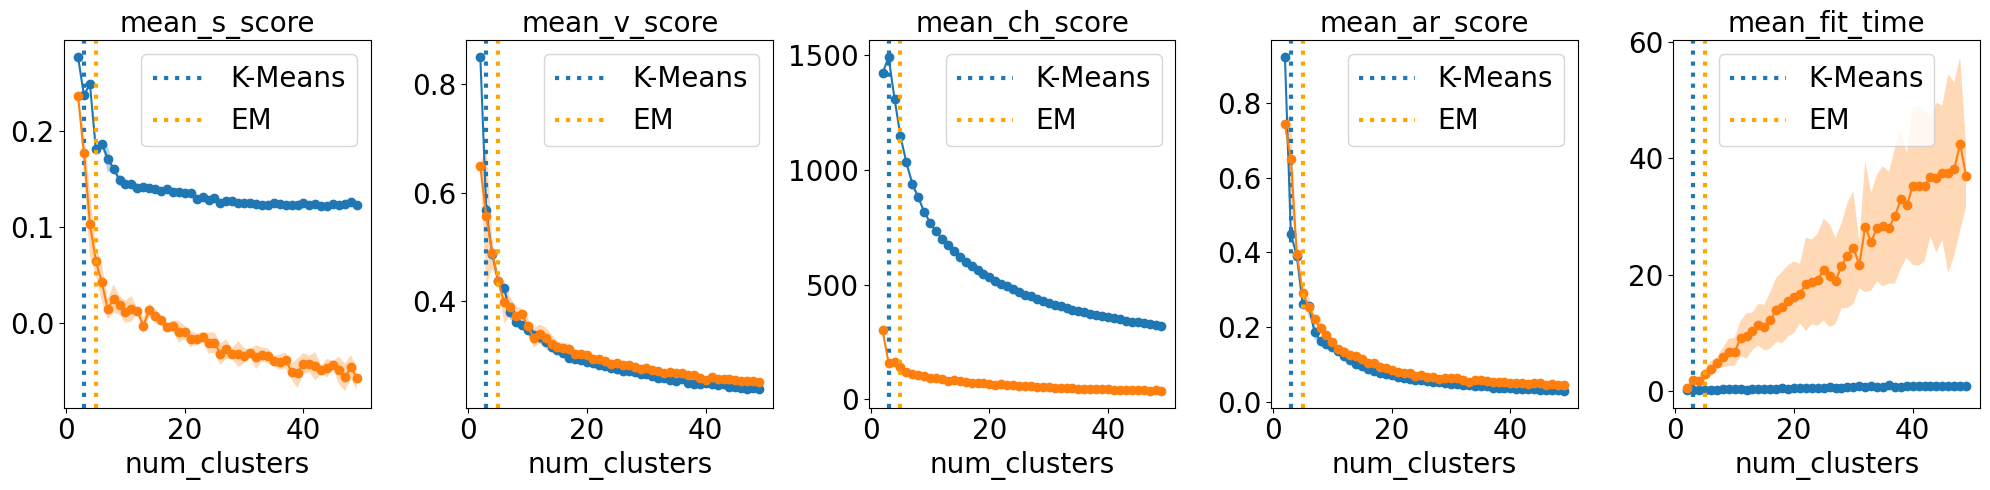

In [255]:
## K Means Clustering Results
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    y_mean = df_km_wine[col_name]
    y_std = df_km_wine[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    axs[count].axvline(x=s_km_cluster_wine.iloc[0,1], color='C0',
                        linestyle=':', label='K-Means', lw=3)

    # EM plot
    y_mean = df_em_score_wine[col_name]
    y_std = df_em_score_wine[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    axs[count].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='EM', lw=3)
    axs[count].legend(fontsize=20)
    # increment index counter for axes array
    count=count+1

# plot fit time for km
y_mean = df_km_wine['mean_fit_time']
y_std = df_km_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
axs[-1].axvline(x=s_km_cluster_wine.iloc[0,1],color='C0',
                        linestyle=':', label='K-Means', lw=3)

# plot fit time for em
y_mean = df_em_score_wine['mean_fit_time']
y_std = df_em_score_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
axs[-1].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='EM', lw=3)
axs[-1].legend(fontsize=20)

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


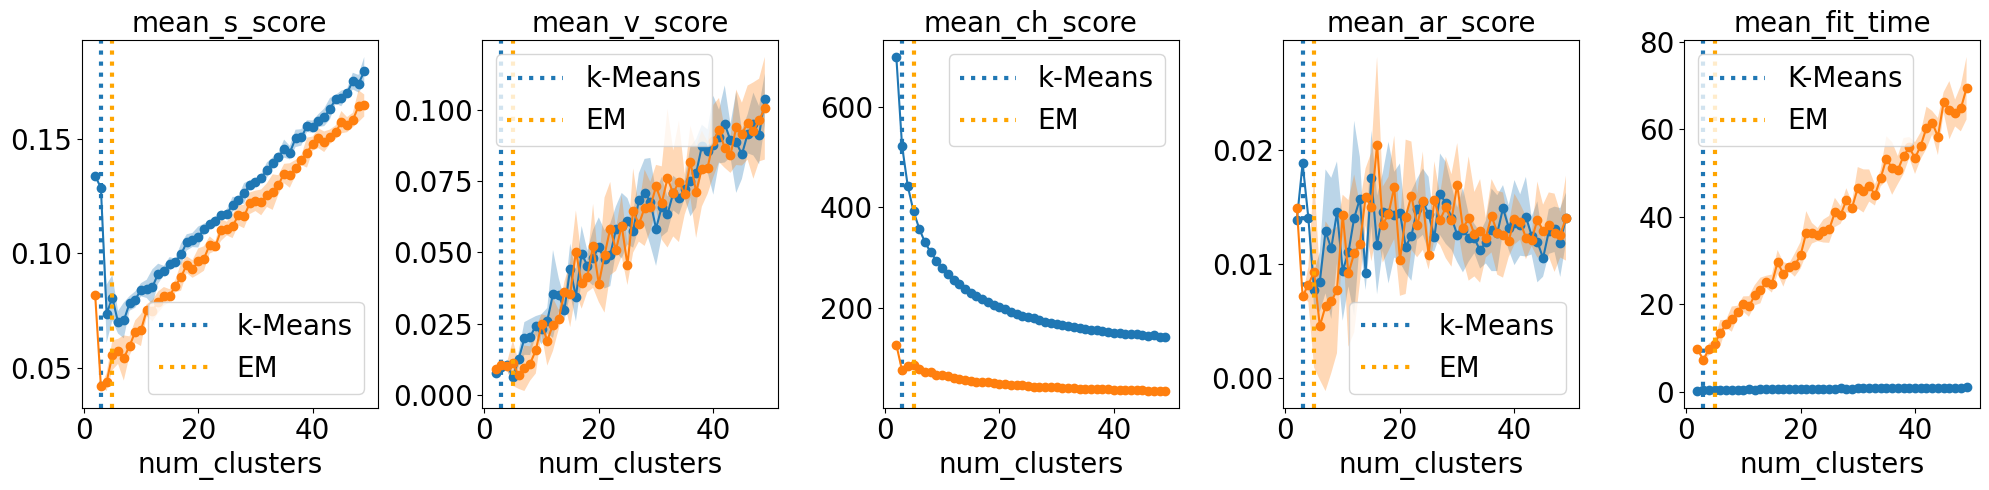

In [254]:
## Clustering Results for Shroom
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_shroom['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    y_mean = df_km_shroom[col_name]
    y_std = df_km_shroom[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    axs[count].axvline(x=s_km_cluster_wine.iloc[0,1], color='C0',
                        linestyle=':', label='k-Means', lw=3)

    # EM plot
    y_mean = df_em_score_shroom[col_name]
    y_std = df_em_score_shroom[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    axs[count].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='EM', lw=3)
    axs[count].legend(fontsize=20)
    # increment index counter for axes array
    count=count+1

# plot fit time for km
y_mean = df_km_shroom['mean_fit_time']
y_std = df_km_shroom['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
axs[-1].axvline(x=s_km_cluster_wine.iloc[0,1],color='C0',
                        linestyle=':', label='K-Means', lw=3)

# plot fit time for em
y_mean = df_em_score_shroom['mean_fit_time']
y_std = df_em_score_shroom['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
axs[-1].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='EM', lw=3)
axs[-1].legend(fontsize=20)

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

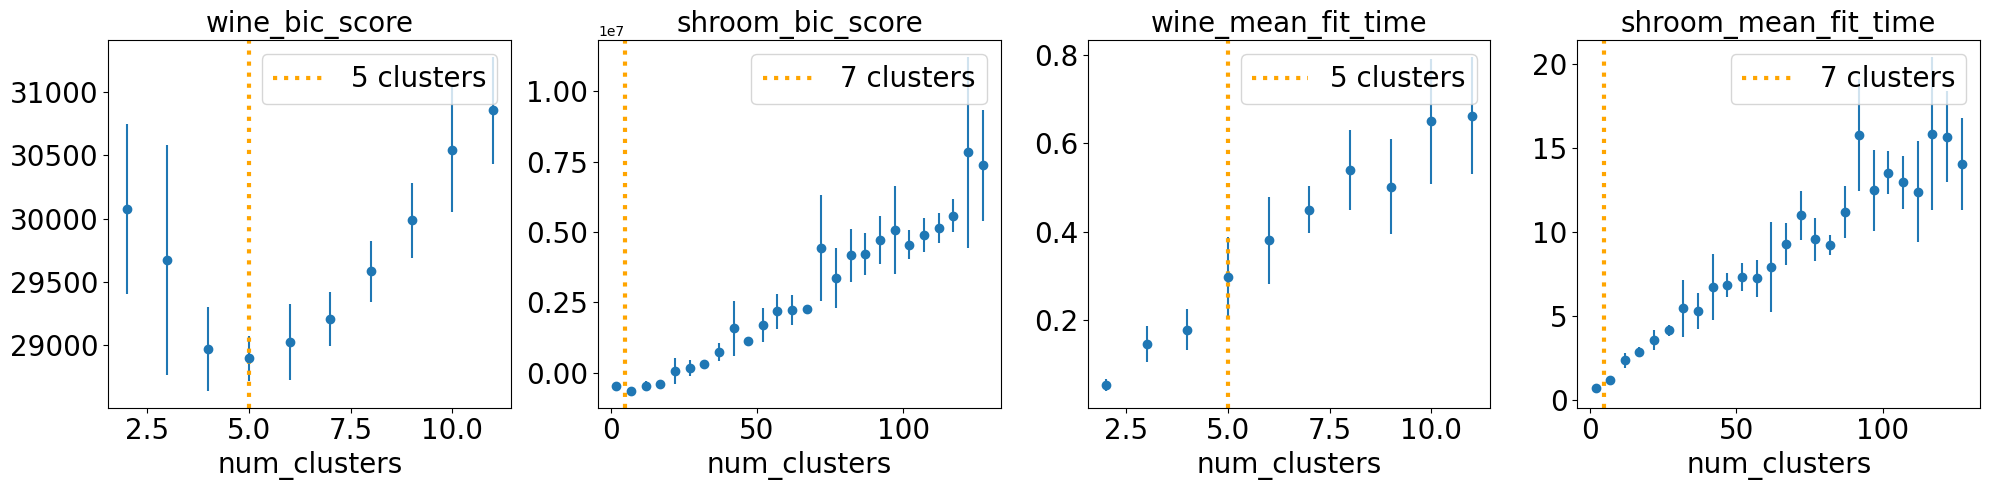

In [22]:
# BIC score for wine
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs= axs.flatten()
x_data = df_em_wine['n_components']
y_mean = df_em_wine['bic_score']
y_std = df_em_wine['std_bic_score']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[0], name='wine_bic_score')

y_mean = df_em_wine['mean_fit_time']
y_std = df_em_wine['std_fit_time']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[2], name='wine_mean_fit_time')

x_data = df_em_shroom['n_components']
y_mean = df_em_shroom['mean_fit_time']
y_std = df_em_shroom['std_fit_time']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[3], name='shroom_mean_fit_time')

y_mean = df_em_shroom['bic_score']
y_std = df_em_shroom['std_bic_score']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[1], name='shroom_bic_score')


axs[0].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='5 clusters', lw=3)

axs[1].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='7 clusters', lw=3)

axs[2].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='5 clusters', lw=3)

axs[3].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='7 clusters', lw=3)

axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
axs[2].legend(fontsize=20)
axs[3].legend(fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
# BIC score for wine
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs= axs.flatten()
x_data = df_em_wine['n_components']
y_mean = df_em_wine['bic_score']
y_std = df_em_wine['std_bic_score']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[0], name='wine_bic_score')

y_mean = df_em_wine['mean_fit_time']
y_std = df_em_wine['std_fit_time']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[2], name='wine_mean_fit_time')

x_data = df_em_shroom['n_components']
y_mean = df_em_shroom['mean_fit_time']
y_std = df_em_shroom['std_fit_time']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[3], name='shroom_mean_fit_time')

y_mean = df_em_shroom['bic_score']
y_std = df_em_shroom['std_bic_score']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[1], name='shroom_bic_score')


axs[0].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='5 clusters', lw=3)

axs[1].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='7 clusters', lw=3)

axs[2].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='5 clusters', lw=3)

axs[3].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='7 clusters', lw=3)

axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
axs[2].legend(fontsize=20)
axs[3].legend(fontsize=20)
plt.tight_layout()
plt.show()

## Dimension Reduction

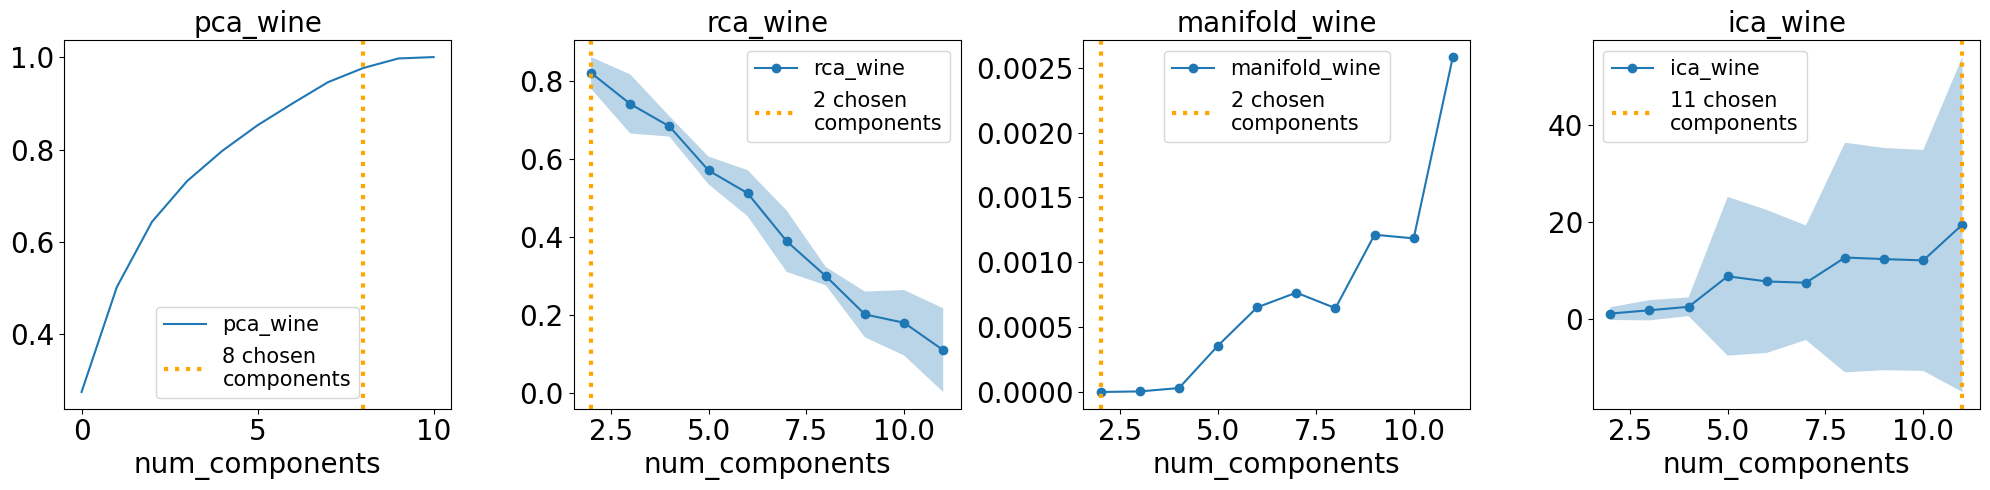

In [25]:
# wine DR
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs =axs.flatten()

x_data = df_pca_wine.index
y_mean = df_pca_wine['0']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[0], name='pca_wine', take_mean=False,
                selected_components=s_pca_cluster_wine.iloc[0,-1])

x_data = df_rca_wine['num_components']
y_mean = df_rca_wine['mean_recon_error']
y_std =df_rca_wine['std_recon_error']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[1], name='rca_wine', take_mean=True,
                 selected_components=s_rca_cluster_wine.iloc[0,-1] )

x_data = df_man_wine['num_components']
y_mean = df_man_wine['mean_recon_error']
y_std =df_man_wine['std_recon_error']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[2], name='manifold_wine', take_mean=True,
                  selected_components=s_man_cluster_wine.iloc[0,-1])

x_data = df_ica_wine['num_components']
y_mean = df_ica_wine['mean_kurtosis']
y_std =df_ica_wine['std_kurtosis']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[3], name='ica_wine', take_mean=True,
                  selected_components=s_ica_cluster_wine.iloc[0,-1])

plt.tight_layout()
plt.show()

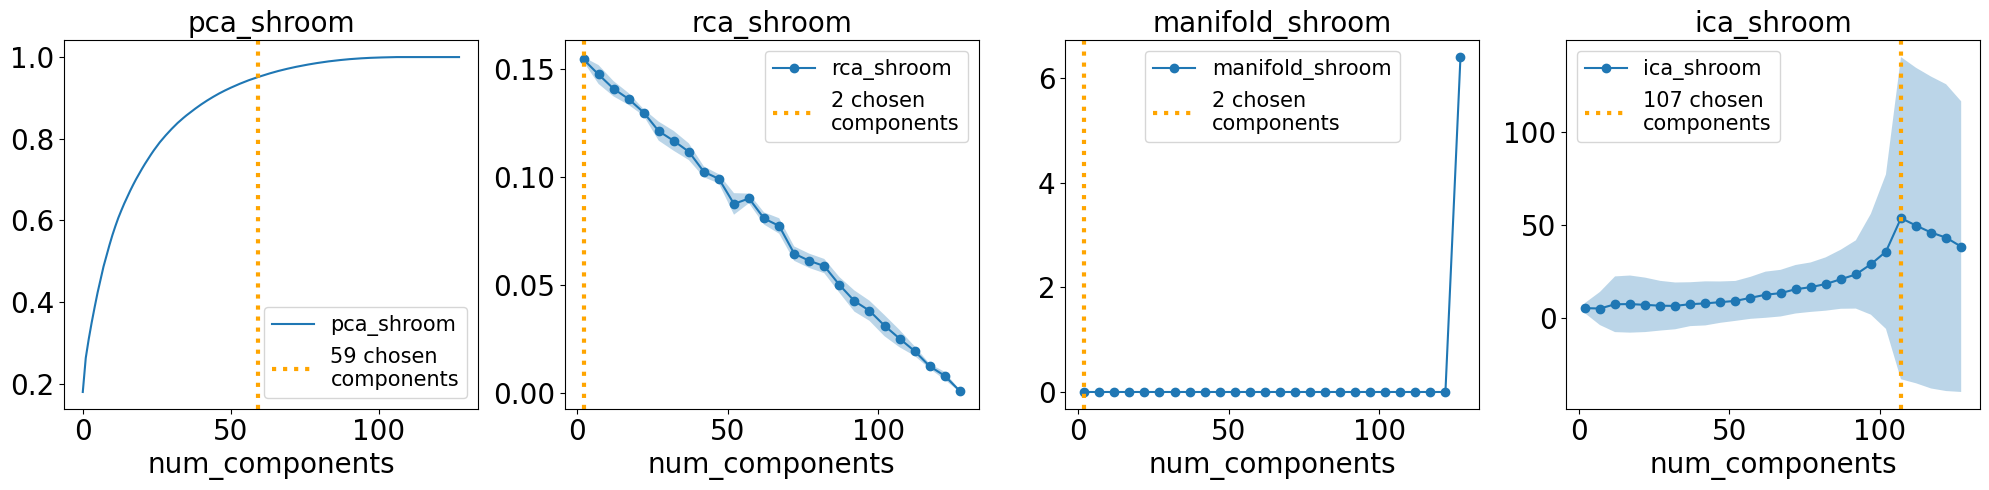

In [256]:
# wine DR
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs =axs.flatten()

x_data = df_pca_shroom.index
y_mean = df_pca_shroom['0']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[0], name='pca_shroom', take_mean=False,
                selected_components=s_pca_cluster_shroom.iloc[0,-1])

x_data = df_rca_shroom['num_components']
y_mean = df_rca_shroom['mean_recon_error']
y_std =df_rca_shroom['std_recon_error']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[1], name='rca_shroom', take_mean=True,
                 selected_components=s_rca_cluster_shroom.iloc[0,-1] )

x_data = df_man_shroom['num_components']
y_mean = df_man_shroom['mean_recon_error']
y_std =df_man_shroom['std_recon_error']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[2], name='manifold_shroom', take_mean=True,
                  selected_components=s_man_cluster_shroom.iloc[0,-1])


x_data = df_ica_shroom['num_components']
y_mean = df_ica_shroom['mean_kurtosis']
y_std =df_ica_shroom['std_kurtosis']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[3], name='ica_shroom', take_mean=True,
                  selected_components=s_ica_cluster_shroom.iloc[0,-1])

plt.tight_layout()
plt.show()

## Clustering on Dimension Reduced Wine Data

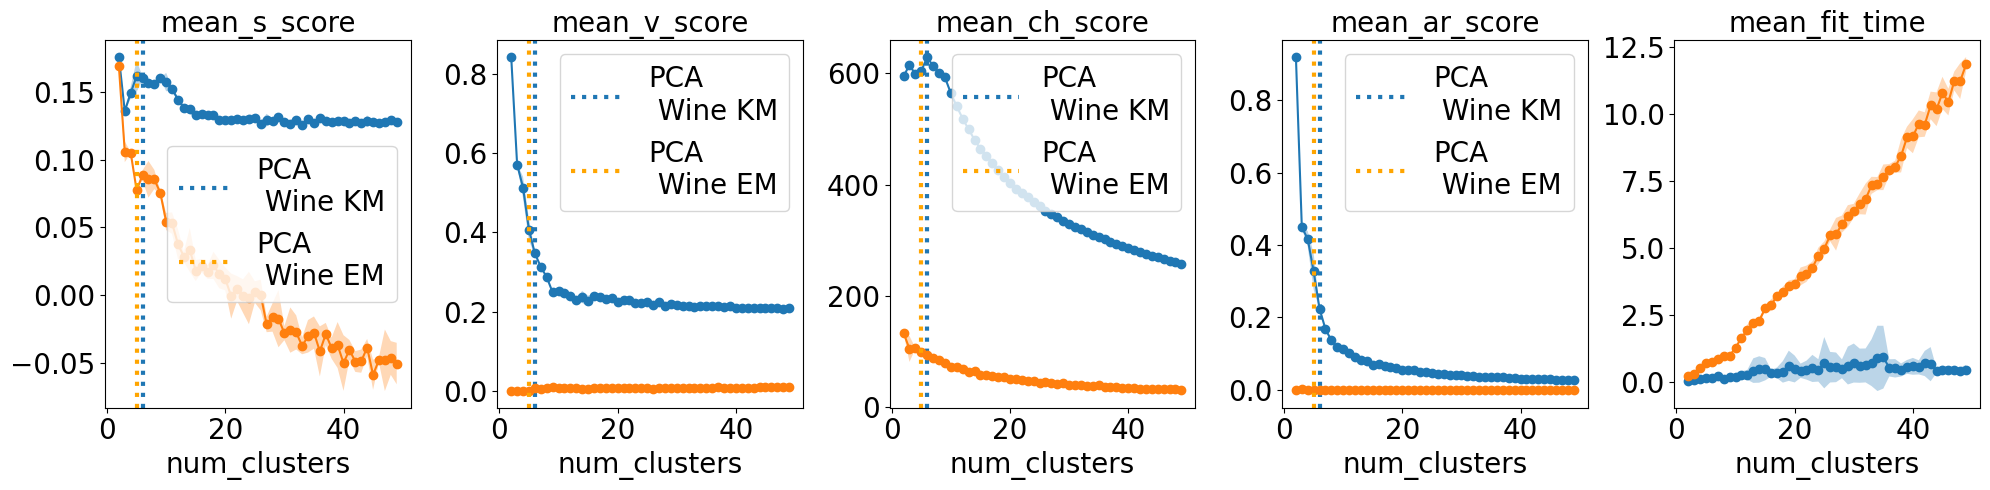

In [36]:
## clustering results pca
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_pca_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    y_mean = df_km_pca_wine[col_name]
    y_std = df_km_pca_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='PCA\n Wine KM',
                         selected_components=s_km_pca_cluster_wine.iloc[0,-1])
    axs[count].axvline(x=s_km_pca_cluster_wine.iloc[0,-1], color='C0',
                    linestyle=':', label='PCA\n Wine KM', lw=3)
    
    # EM plot
    y_mean = df_em_score_pca_wine[col_name]
    y_std = df_em_score_pca_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='PCA\n Wine EM',
                         selected_components=s_em_cluster_pca_wine.iloc[0,-1])
    axs[count].axvline(x=s_em_cluster_pca_wine.iloc[0,-1], color='orange',
                linestyle=':', label='PCA\n Wine EM', lw=3)
    
    axs[count].legend(fontsize=20)
    # increment index counter for axes array
    count=count+1

# plot fit time for km
y_mean = df_km_pca_wine['mean_fit_time']
y_std = df_km_pca_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# plot fit time for em
y_mean = df_em_score_pca_wine['mean_fit_time']
y_std = df_em_score_pca_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

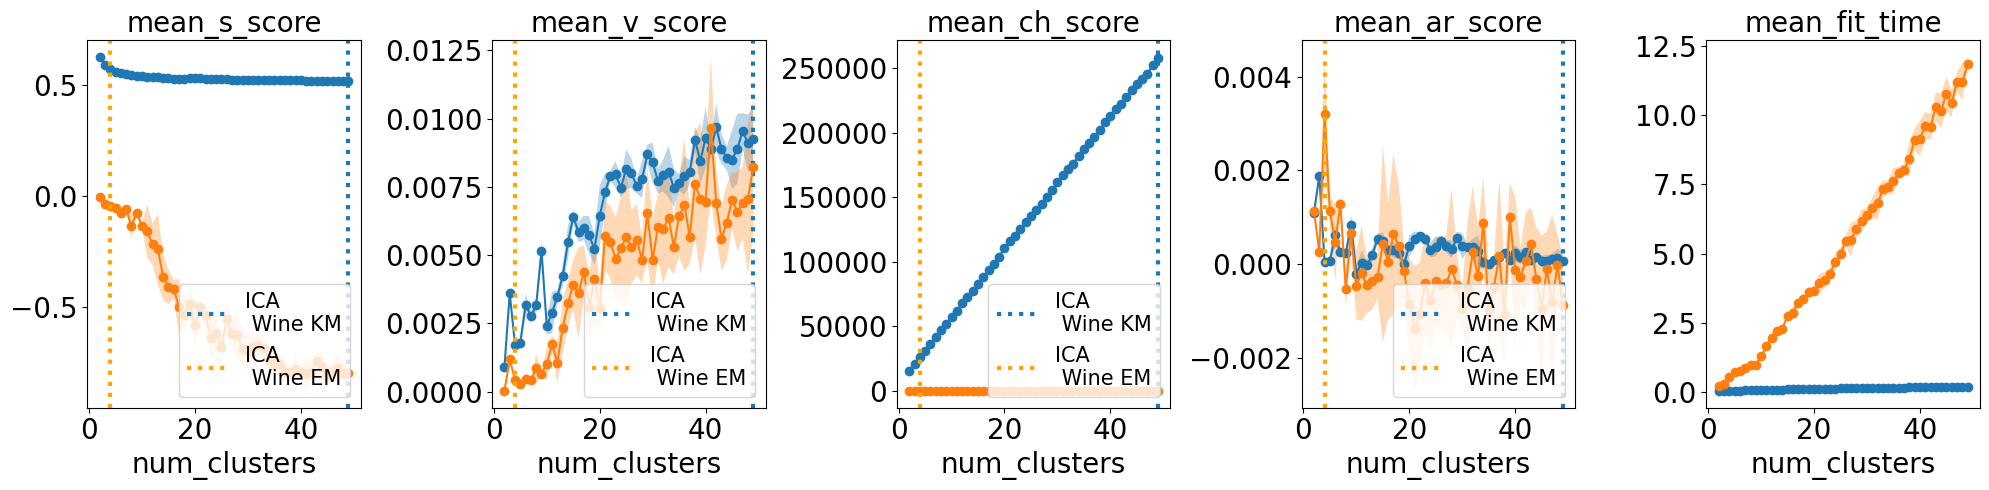

In [85]:
## clustering results pca
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_ica_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    y_mean = df_km_ica_wine[col_name]
    y_std = df_km_ica_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='ICA\n Wine KM',
                         selected_components=s_km_ica_cluster_wine.iloc[0,-1])
    axs[count].axvline(x=s_km_ica_cluster_wine.iloc[0,-1], color='C0',
                    linestyle=':', label='ICA\n Wine KM', lw=3)
    
    # EM plot
    y_mean = df_em_score_ica_wine[col_name]
    y_std = df_em_score_ica_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='ICA\n Wine EM',
                         selected_components=s_em_cluster_ica_wine.iloc[0,-1])
    axs[count].axvline(x=s_em_cluster_ica_wine.iloc[0,-1], color='orange',
                linestyle=':', label='ICA\n Wine EM', lw=3)
    
    axs[count].legend(fontsize=15, loc='lower right')
    # increment index counter for axes array
    count=count+1

# plot fit time for km
y_mean = df_km_pca_wine['mean_fit_time']
y_std = df_km_pca_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# plot fit time for em
y_mean = df_em_score_pca_wine['mean_fit_time']
y_std = df_em_score_pca_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

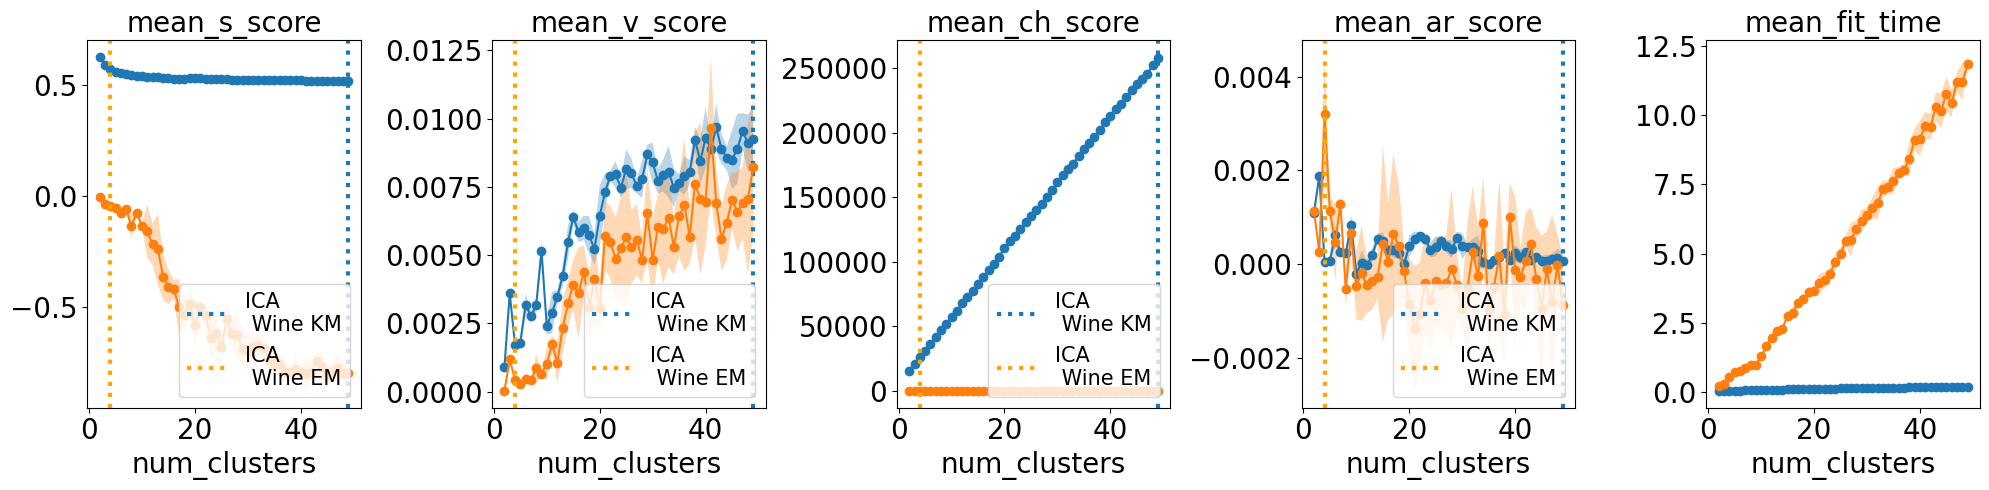

In [86]:
## clustering results pca
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_pca_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    y_mean = df_km_ica_wine[col_name]
    y_std = df_km_ica_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='ICA\n Wine KM',
                         selected_components=s_km_ica_cluster_wine.iloc[0,-1])
    axs[count].axvline(x=s_km_ica_cluster_wine.iloc[0,-1], color='C0',
                    linestyle=':', label='ICA\n Wine KM', lw=3)
    
    # EM plot
    y_mean = df_em_score_ica_wine[col_name]
    y_std = df_em_score_ica_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='ICA\n Wine EM',
                         selected_components=s_em_cluster_ica_wine.iloc[0,-1])
    axs[count].axvline(x=s_em_cluster_ica_wine.iloc[0,-1], color='orange',
                linestyle=':', label='ICA\n Wine EM', lw=3)
    
    axs[count].legend(fontsize=15, loc='lower right')
    # increment index counter for axes array
    count=count+1

# plot fit time for km
y_mean = df_km_pca_wine['mean_fit_time']
y_std = df_km_pca_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# plot fit time for em
y_mean = df_em_score_pca_wine['mean_fit_time']
y_std = df_em_score_pca_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


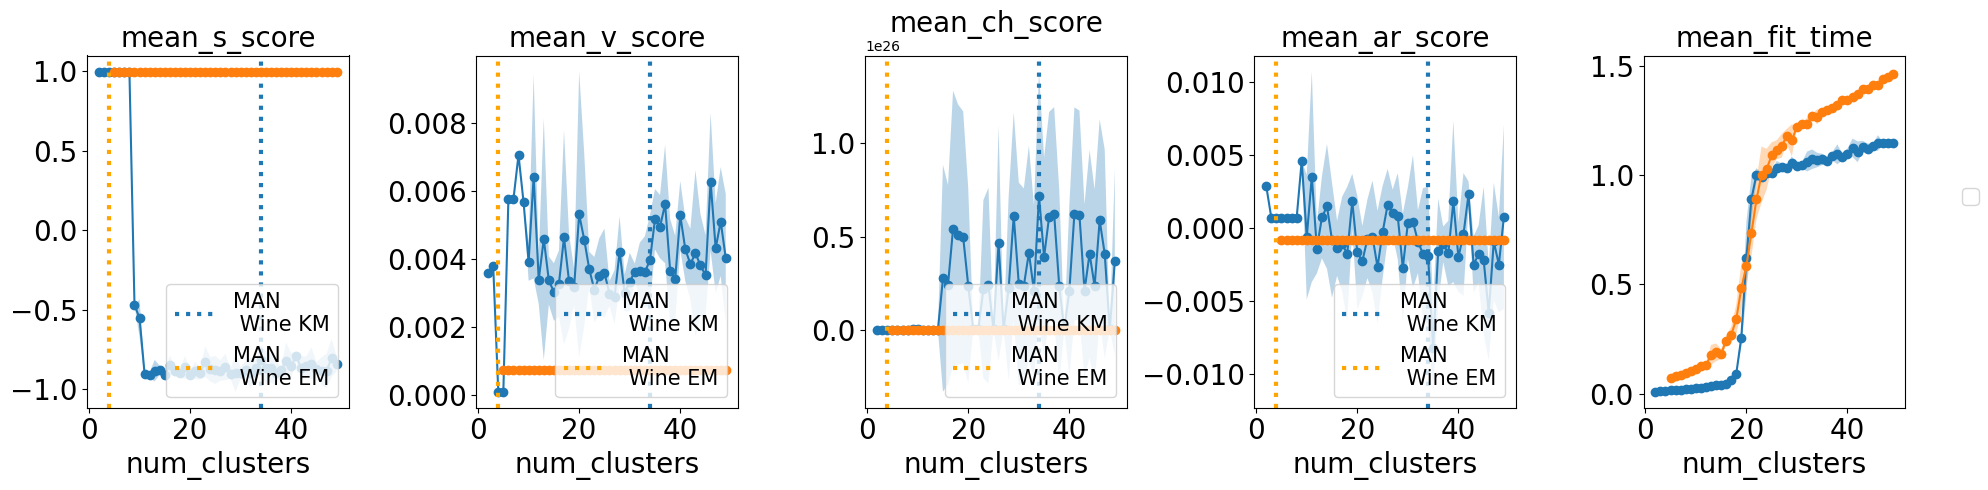

In [182]:
## clustering results pca
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_man_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    x_data = df_km_man_wine['num_clusters']
    y_mean = df_km_man_wine[col_name]
    y_std = df_km_man_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='MAN\n Wine KM',
                         selected_components=s_km_man_cluster_wine.iloc[0,-1])
    axs[count].axvline(x=s_km_man_cluster_wine.iloc[0,-1], color='C0',
                    linestyle=':', label='MAN\n Wine KM', lw=3)
    
    # EM plot
    x_data = df_em_score_man_wine['num_clusters']
    y_mean = df_em_score_man_wine[col_name]
    y_std = df_em_score_man_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='MAN\n Wine EM',
                         selected_components=s_em_cluster_man_wine.iloc[0,-1])
    axs[count].axvline(x=s_em_cluster_man_wine.iloc[0,-1], color='orange',
                linestyle=':', label='MAN\n Wine EM', lw=3)
    
    axs[count].legend(fontsize=15, loc='lower right')
    # increment index counter for axes array
    count=count+1

# plot fit time for km
x_data = df_km_man_wine['num_clusters']
y_mean = df_km_man_wine['mean_fit_time']
y_std = df_km_man_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# plot fit time for em
x_data = df_em_score_man_wine['num_clusters']
y_mean = df_em_score_man_wine['mean_fit_time']
y_std = df_em_score_man_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


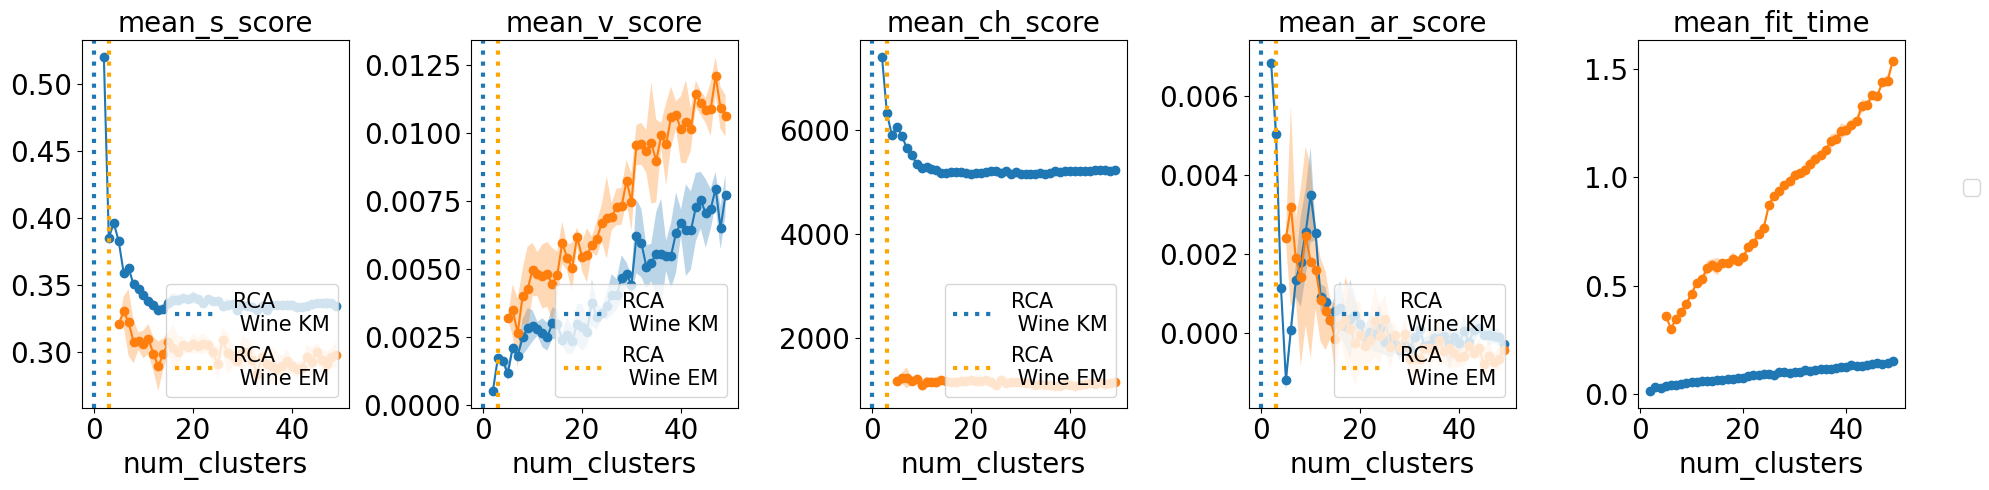

In [184]:
## clustering results pca
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_rca_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    x_data = df_km_rca_wine['num_clusters']
    y_mean = df_km_rca_wine[col_name]
    y_std = df_km_rca_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='RCA\n Wine KM',
                         selected_components=s_km_rca_cluster_wine.iloc[0,-1])
    axs[count].axvline(x=s_km_rca_cluster_wine.iloc[0,-1], color='C0',
                    linestyle=':', label='RCA\n Wine KM', lw=3)
    
    # EM plot
    x_data = df_em_score_rca_wine['num_clusters']
    y_mean = df_em_score_rca_wine[col_name]
    y_std = df_em_score_rca_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='RCA\n Wine EM',
                         selected_components=s_em_cluster_rca_wine.iloc[0,-1])
    axs[count].axvline(x=s_em_cluster_rca_wine.iloc[0,-1], color='orange',
                linestyle=':', label='RCA\n Wine EM', lw=3)
    
    axs[count].legend(fontsize=15, loc='lower right')
    # increment index counter for axes array
    count=count+1

# plot fit time for km
x_data = df_km_rca_wine['num_clusters']
y_mean = df_km_rca_wine['mean_fit_time']
y_std = df_km_rca_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# plot fit time for em
x_data = df_em_score_rca_wine['num_clusters']
y_mean = df_em_score_rca_wine['mean_fit_time']
y_std = df_em_score_rca_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

## Clustering on Dimension Reduced Shroom Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


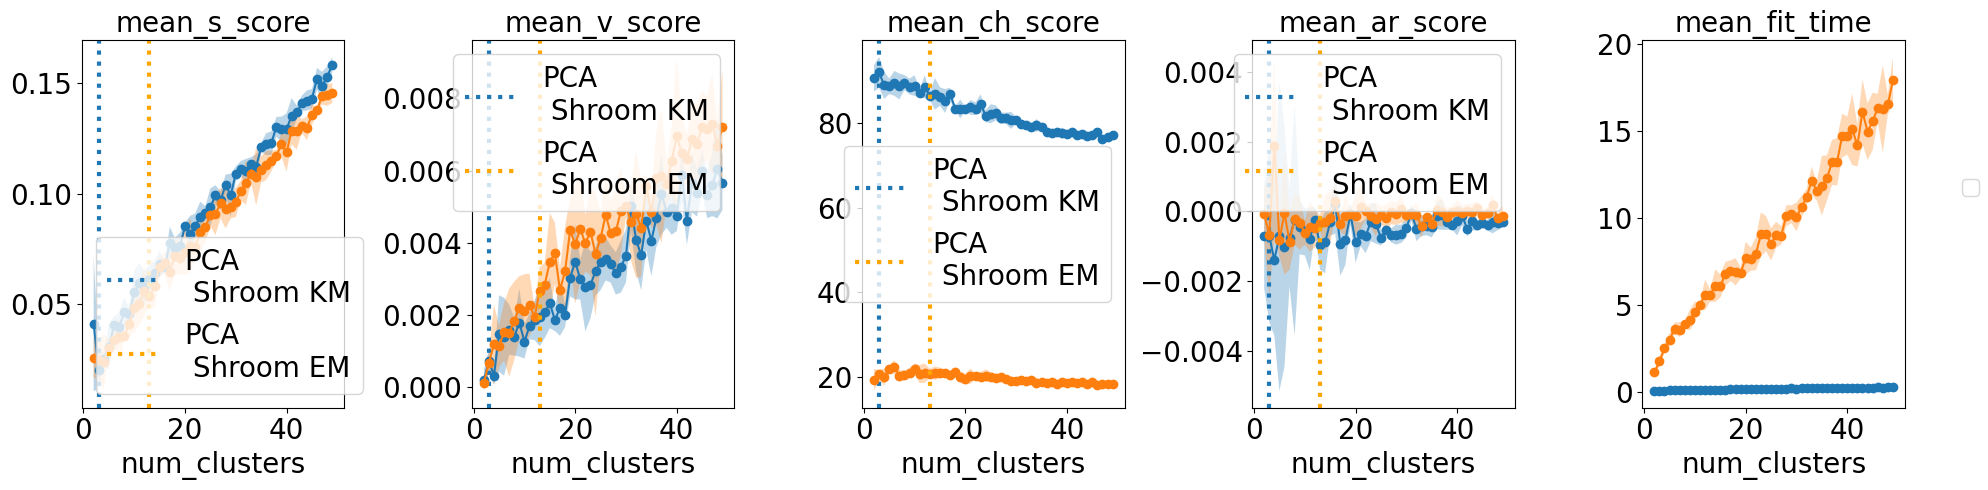

In [260]:
## clustering results pca
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_pca_shroom['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    y_mean = df_km_pca_shroom[col_name]
    y_std = df_km_pca_shroom[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='PCA\n Shroom KM',
                         selected_components=s_km_pca_cluster_shroom.iloc[0,-1])
    axs[count].axvline(x=s_km_pca_cluster_shroom.iloc[0,-1], color='C0',
                    linestyle=':', label='PCA\n Shroom KM', lw=3)
    
    # EM plot
    y_mean = df_em_score_pca_shroom[col_name]
    y_std = df_em_score_pca_shroom[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='PCA\n Shroom EM',
                         selected_components=s_em_cluster_pca_shroom.iloc[0,-1])
    axs[count].axvline(x=s_em_cluster_pca_shroom.iloc[0,-1], color='orange',
                linestyle=':', label='PCA\n Shroom EM', lw=3)
    
    axs[count].legend(fontsize=20)
    # increment index counter for axes array
    count=count+1

# plot fit time for km
y_mean = df_km_pca_shroom['mean_fit_time']
y_std = df_km_pca_shroom['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# plot fit time for em
y_mean = df_em_score_pca_shroom['mean_fit_time']
y_std = df_em_score_pca_shroom['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


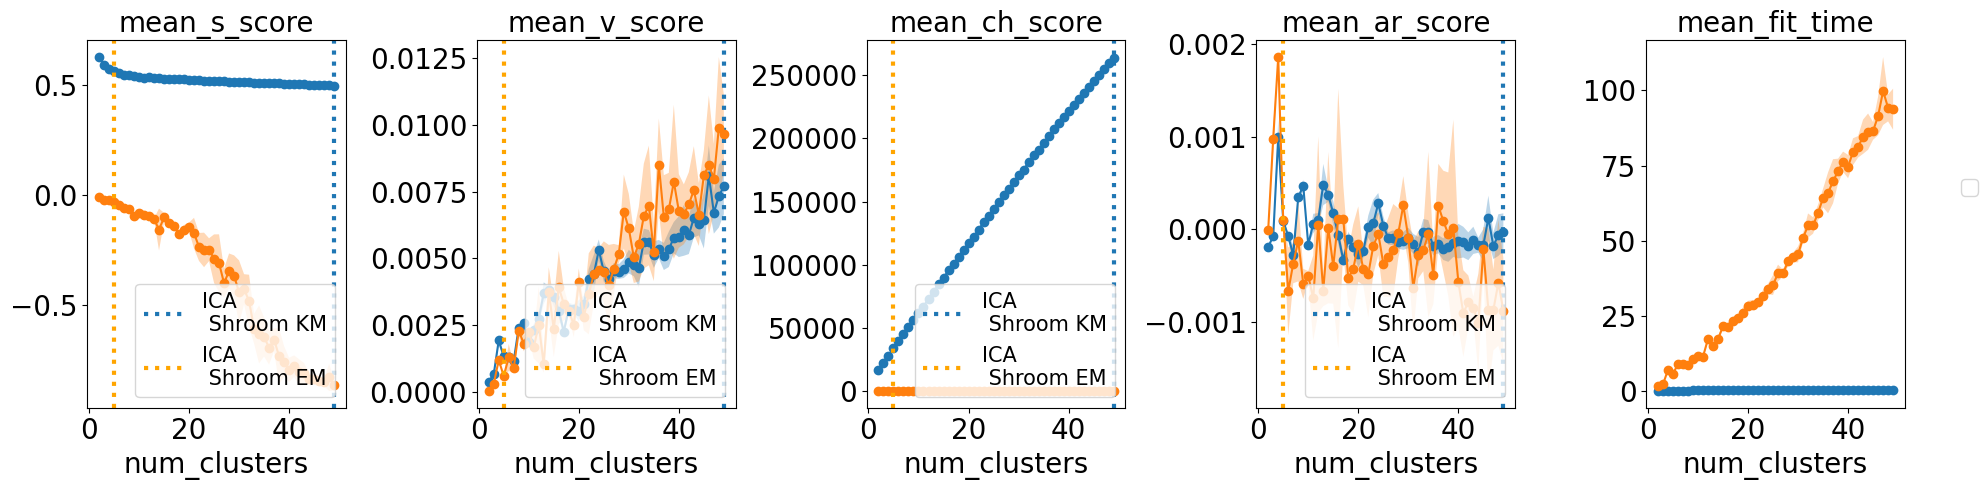

In [269]:
## clustering results pca
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_ica_shroom['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    x_data = df_km_ica_shroom['num_clusters']
    y_mean = df_km_ica_shroom[col_name]
    y_std = df_km_ica_shroom[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='ICA\n Shroom KM',
                         selected_components=s_km_ica_cluster_shroom.iloc[0,-1])
    axs[count].axvline(x=s_km_ica_cluster_shroom.iloc[0,-1], color='C0',
                    linestyle=':', label='ICA\n Shroom KM', lw=3)
    
    # EM plot
    x_data = df_em_score_ica_shroom['num_clusters']
    y_mean = df_em_score_ica_shroom[col_name]
    y_std = df_em_score_ica_shroom[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='ICA\n Shroom EM',
                         selected_components=s_em_cluster_ica_shroom.iloc[0,-1])
    axs[count].axvline(x=s_em_cluster_ica_shroom.iloc[0,-1], color='orange',
                linestyle=':', label='ICA\n Shroom EM', lw=3)
    
    axs[count].legend(fontsize=15,loc='lower right')
    # increment index counter for axes array
    count=count+1

# plot fit time for km
x_data = x_data = df_km_ica_shroom['num_clusters']
y_mean = df_km_ica_shroom['mean_fit_time']
y_std = df_km_ica_shroom['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# plot fit time for em
x_data = df_em_score_ica_shroom['num_clusters']
y_mean = df_em_score_ica_shroom['mean_fit_time']
y_std = df_em_score_ica_shroom['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


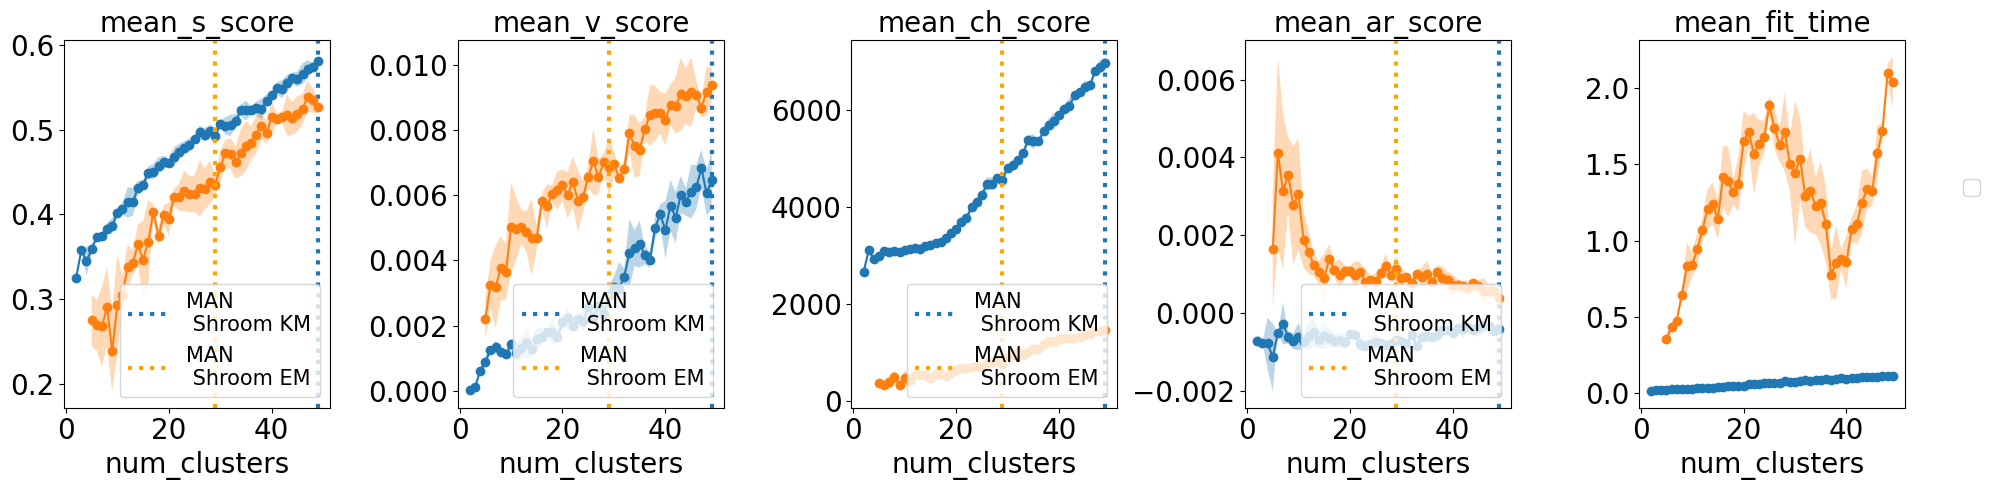

In [268]:
## clustering results pca
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_man_shroom['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    x_data = df_km_man_shroom['num_clusters']
    y_mean = df_km_man_shroom[col_name]
    y_std = df_km_man_shroom[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='MAN\n Shroom KM',
                         selected_components=s_km_man_cluster_shroom.iloc[0,-1])
    axs[count].axvline(x=s_km_man_cluster_shroom.iloc[0,-1], color='C0',
                    linestyle=':', label='MAN\n Shroom KM', lw=3)
    
    # EM plot
    x_data = df_em_score_man_shroom['num_clusters']
    y_mean = df_em_score_man_shroom[col_name]
    y_std = df_em_score_man_shroom[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, 
                         label='MAN\n Shroom EM',
                         selected_components=s_em_cluster_man_shroom.iloc[0,-1])
    axs[count].axvline(x=s_em_cluster_man_shroom.iloc[0,-1], color='orange',
                linestyle=':', label='MAN\n Shroom EM', lw=3)
    
    axs[count].legend(fontsize=15,loc='lower right')
    # increment index counter for axes array
    count=count+1

# plot fit time for km
x_data = x_data = df_km_man_shroom['num_clusters']
y_mean = df_km_man_shroom['mean_fit_time']
y_std = df_km_man_shroom['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# plot fit time for em
x_data = df_em_score_man_shroom['num_clusters']
y_mean = df_em_score_man_shroom['mean_fit_time']
y_std = df_em_score_man_shroom['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

## Neural Network

In [70]:
neural_folder = join('neural_net_curves')

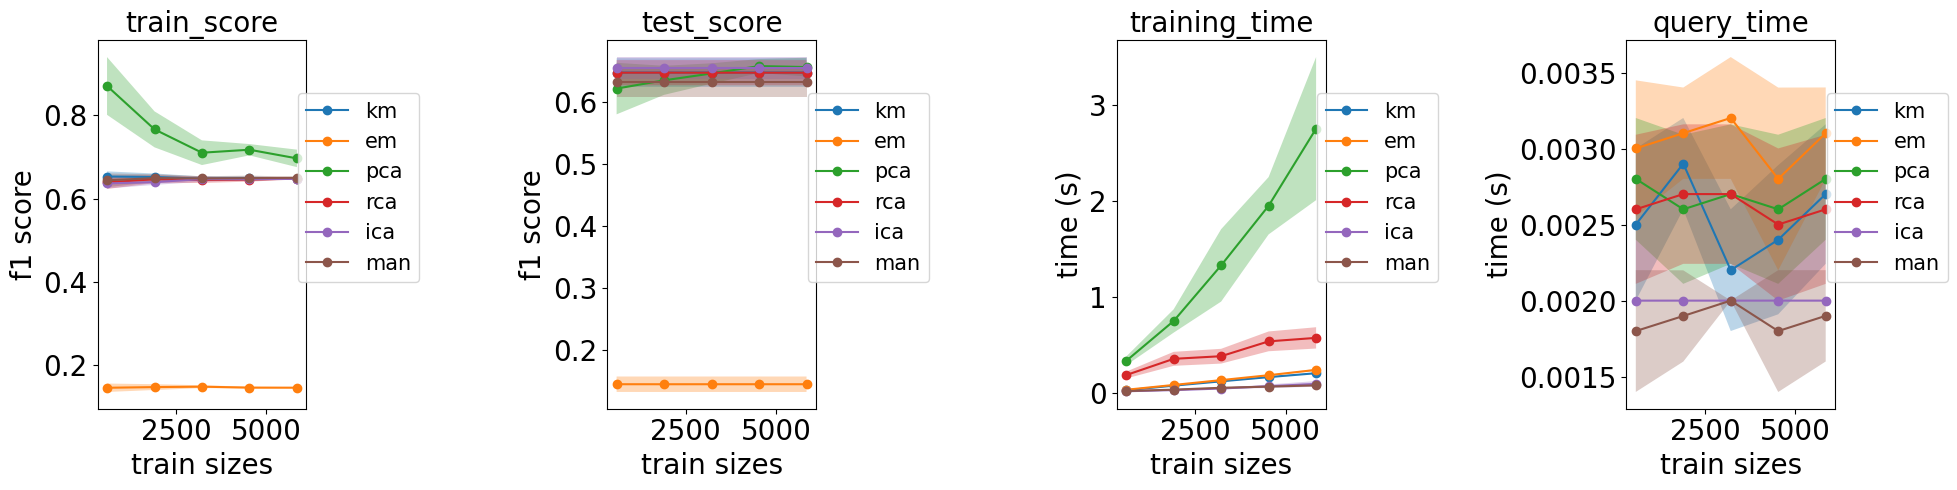

In [178]:
name_lst= ['km','em','pca','rca','ica','man']
fig,axs = plt.subplots(1,4, figsize=(20,5))
axs = axs.flatten()
count = 0
x_data = train_size_wines['train_sizes']

for name in name_lst:
    
    y_mean = pd.read_csv(join(neural_folder,f'train_mean_{name}_wine.csv'),index_col=0)['train_mean']
    y_std = pd.read_csv(join(neural_folder,f'train_sd_{name}_wine.csv'),index_col=0)['train_sd']
    plot_curve(x_data,y_mean,y_std,x_name='train sizes', name='train_score', axs=axs[0],label=name)
    # axs.legend(fontsize=15, loc='lower right')
    y_mean = pd.read_csv(join(neural_folder,f'test_mean_{name}_wine.csv'),index_col=0)['test_mean']
    y_std = pd.read_csv(join(neural_folder,f'test_sd_{name}_wine.csv'),index_col=0)['test_sd']
    plot_curve(x_data,y_mean,y_std,x_name='train sizes', name='test_score',axs=axs[1],label=name)
    y_mean = pd.read_csv(join(neural_folder,f'fit_mean_{name}_wine.csv'),index_col=0)['fit_mean']
    y_std = pd.read_csv(join(neural_folder,f'fit_sd_{name}_wine.csv'),index_col=0)['fit_sd']
    plot_curve(x_data,y_mean,y_std,x_name='train sizes', name='training_time',axs=axs[2],label=name)
    y_mean = pd.read_csv(join(neural_folder,f'score_mean_{name}_wine.csv'),index_col=0)['score_mean']
    y_std = pd.read_csv(join(neural_folder,f'score_sd_{name}_wine.csv'),index_col=0)['score_sd']
    plot_curve(x_data,y_mean,y_std,x_name='train sizes', name='query_time',axs=axs[3],label=name)

axs[0].set_ylabel('f1 score', fontsize=20)
axs[1].set_ylabel('f1 score', fontsize=20)
axs[2].set_ylabel('time (s)', fontsize=20)
axs[3].set_ylabel('time (s)', fontsize=20)

plt.tight_layout()
plt.show()


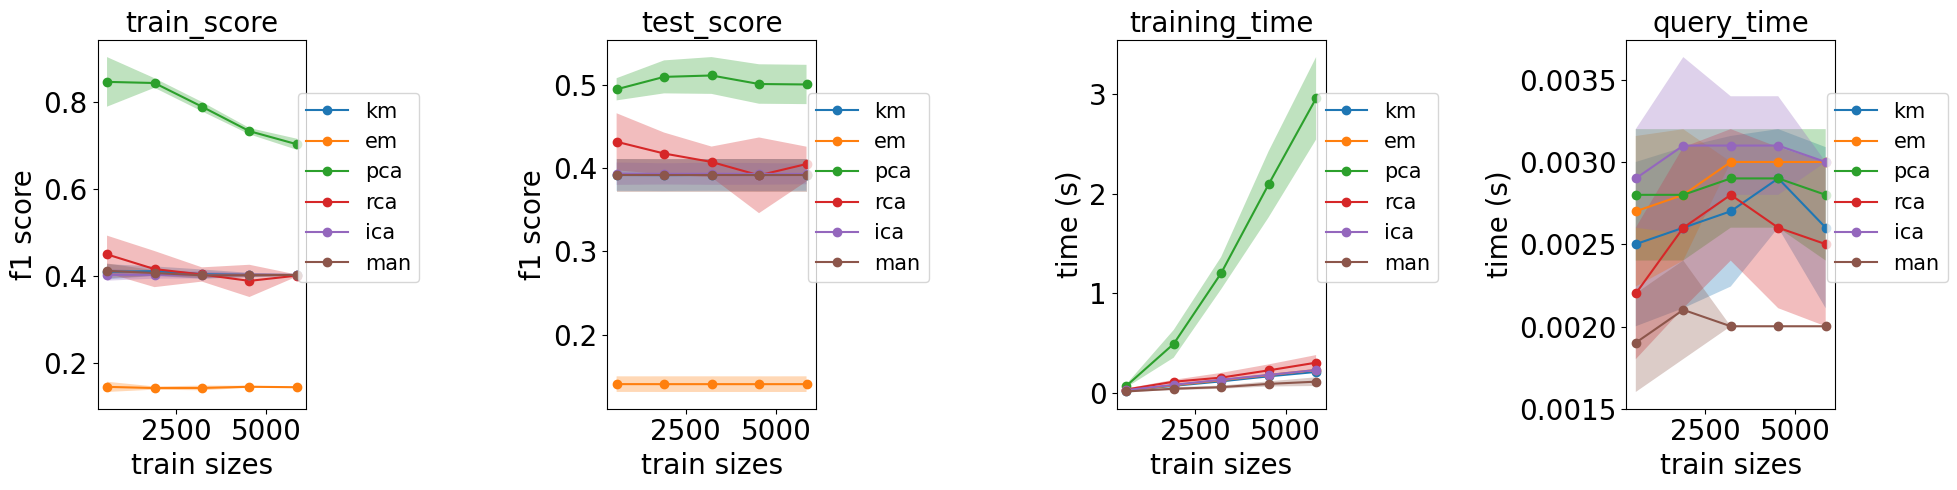

In [179]:
name_lst= ['km','em','pca','rca','ica','man']
fig,axs = plt.subplots(1,4, figsize=(20,5))
axs = axs.flatten()
count = 0
x_data = train_size_wines['train_sizes']

for name in name_lst:
    
    y_mean = pd.read_csv(join(neural_folder,f'train_mean_{name}_shroom.csv'),index_col=0)['train_mean']
    y_std = pd.read_csv(join(neural_folder,f'train_sd_{name}_shroom.csv'),index_col=0)['train_sd']
    plot_curve(x_data,y_mean,y_std,x_name='train sizes', name='train_score', axs=axs[0],label=name)
    # axs.legend(fontsize=15, loc='lower right')
    y_mean = pd.read_csv(join(neural_folder,f'test_mean_{name}_shroom.csv'),index_col=0)['test_mean']
    y_std = pd.read_csv(join(neural_folder,f'test_sd_{name}_shroom.csv'),index_col=0)['test_sd']
    plot_curve(x_data,y_mean,y_std,x_name='train sizes', name='test_score',axs=axs[1],label=name)
    y_mean = pd.read_csv(join(neural_folder,f'fit_mean_{name}_shroom.csv'),index_col=0)['fit_mean']
    y_std = pd.read_csv(join(neural_folder,f'fit_sd_{name}_shroom.csv'),index_col=0)['fit_sd']
    plot_curve(x_data,y_mean,y_std,x_name='train sizes', name='training_time',axs=axs[2],label=name)
    y_mean = pd.read_csv(join(neural_folder,f'score_mean_{name}_shroom.csv'),index_col=0)['score_mean']
    y_std = pd.read_csv(join(neural_folder,f'score_sd_{name}_shroom.csv'),index_col=0)['score_sd']
    plot_curve(x_data,y_mean,y_std,x_name='train sizes', name='query_time',axs=axs[3],label=name)

axs[0].set_ylabel('f1 score', fontsize=20)
axs[1].set_ylabel('f1 score', fontsize=20)
axs[2].set_ylabel('time (s)', fontsize=20)
axs[3].set_ylabel('time (s)', fontsize=20)

plt.tight_layout()
plt.show()


## Clustering Visualizations

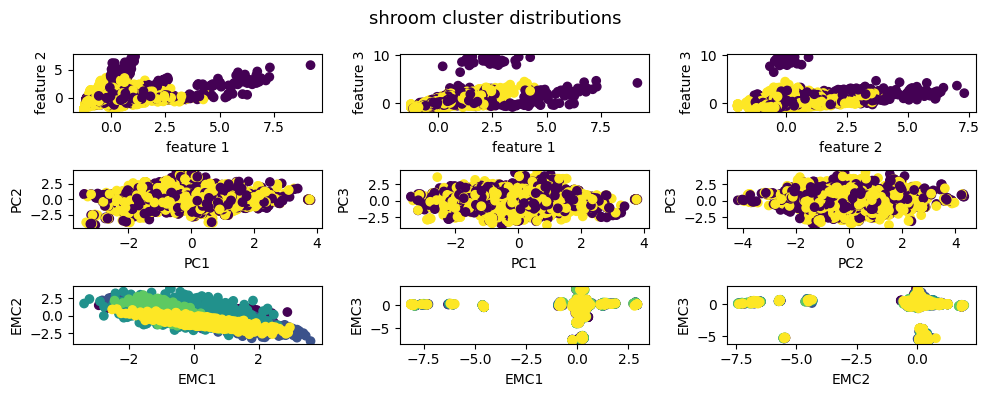

In [249]:
## Original Distributions mushroom
fig, axs = plt.subplots(3,3,figsize=(10,4))
axs = axs.flatten()
axs[0].scatter(x_shroom.iloc[:,-1], x_shroom.iloc[:,-2],c=y_shroom)
axs[0].set_ylabel('feature 2')
axs[0].set_xlabel('feature 1')
axs[1].scatter(x_shroom.iloc[:,-1], x_shroom.iloc[:,-3],c=y_shroom)
axs[1].set_ylabel('feature 3')
axs[1].set_xlabel('feature 1')
axs[2].scatter(x_shroom.iloc[:,-2], x_shroom.iloc[:,-3],c=y_shroom)
axs[2].set_ylabel('feature 3')
axs[2].set_xlabel('feature 2')

## Transformed Distributions mushroom
axs[3].scatter(x_pca_shroom.iloc[:,-1], x_pca_shroom.iloc[:,-2],c=y_shroom)
axs[3].set_ylabel('PC2')
axs[3].set_xlabel('PC1')
axs[4].scatter(x_pca_shroom.iloc[:,-1], x_pca_shroom.iloc[:,-3],c=y_shroom)
axs[4].set_ylabel('PC3')
axs[4].set_xlabel('PC1')
axs[5].scatter(x_pca_shroom.iloc[:,-2], x_pca_shroom.iloc[:,-3],c=y_shroom)
axs[5].set_ylabel('PC3')
axs[5].set_xlabel('PC2')
plt.tight_layout()

## Transformed Distributions mushroom
axs[6].scatter(x_em_shroom.iloc[:,-2], x_em_shroom.iloc[:,-5],c=x_em_shroom.iloc[:,-1])
axs[6].set_ylabel('EMC2')
axs[6].set_xlabel('EMC1')
axs[7].scatter(x_ica_shroom.iloc[:,-2], x_ica_shroom.iloc[:,-4],c=x_em_shroom.iloc[:,-1])
axs[7].set_ylabel('EMC3')
axs[7].set_xlabel('EMC1')
axs[8].scatter(x_ica_shroom.iloc[:,-5], x_ica_shroom.iloc[:,-10],c=x_em_shroom.iloc[:,-1])
axs[8].set_ylabel('EMC3')
axs[8].set_xlabel('EMC2')
fig.suptitle('shroom cluster distributions', fontsize=13)
plt.tight_layout()

## Transformed Distributions mushroom
# axs[3].scatter(x_ica_shroom.iloc[:,-1], x_ica_shroom.iloc[:,-2],c=y_shroom)
# axs[3].set_ylabel('IC2')
# axs[3].set_xlabel('IC1')
# axs[4].scatter(x_ica_shroom.iloc[:,-1], x_ica_shroom.iloc[:,-3],c=y_shroom)
# axs[4].set_ylabel('IC3')
# axs[4].set_xlabel('IC1')
# axs[5].scatter(x_ica_shroom.iloc[:,-2], x_ica_shroom.iloc[:,-3],c=y_shroom)
# axs[5].set_ylabel('IC3')
# axs[5].set_xlabel('IC2')
# plt.tight_layout()

In [ ]:
## Transformed Distributions mushroom
axs[3].scatter(x_ica_shroom.iloc[:,-1], x_ica_shroom.iloc[:,-2],c=y_shroom)
axs[3].set_ylabel('PC2')
axs[3].set_xlabel('PC1')
axs[4].scatter(x_ica_shroom.iloc[:,-1], x_ica_shroom.iloc[:,-3],c=y_shroom)
axs[4].set_ylabel('PC3')
axs[4].set_xlabel('PC1')
axs[5].scatter(x_ica_shroom.iloc[:,-2], x_ica_shroom.iloc[:,-3],c=y_shroom)
axs[5].set_ylabel('PC3')
axs[5].set_xlabel('PC2')
plt.tight_layout()

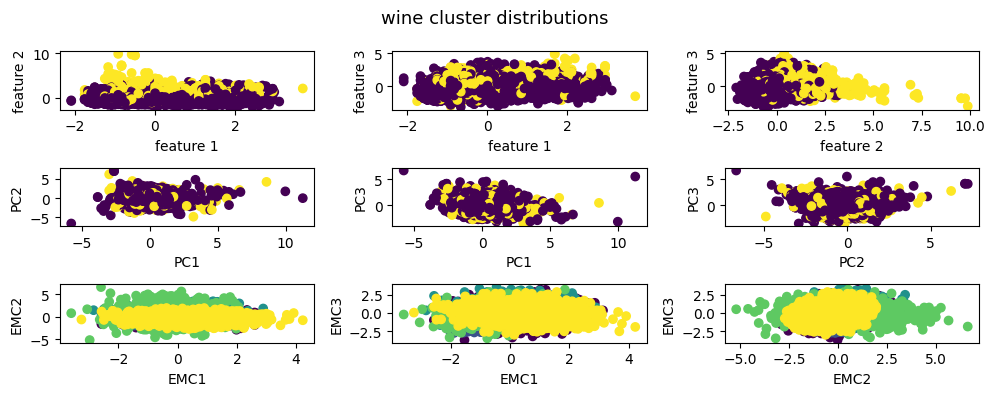

In [250]:
## Original Distributions mushroom
fig, axs = plt.subplots(3,3,figsize=(10,4))
axs = axs.flatten()
axs[0].scatter(x_wine.iloc[:,-1], x_wine.iloc[:,-2],c=y_wine)
axs[0].set_ylabel('feature 2')
axs[0].set_xlabel('feature 1')
axs[1].scatter(x_wine.iloc[:,-1], x_wine.iloc[:,-3],c=y_wine)
axs[1].set_ylabel('feature 3')
axs[1].set_xlabel('feature 1')
axs[2].scatter(x_wine.iloc[:,-2], x_wine.iloc[:,-3],c=y_wine)
axs[2].set_ylabel('feature 3')
axs[2].set_xlabel('feature 2')

axs[3].scatter(x_pca_wine.iloc[:,-1], x_pca_wine.iloc[:,-2],c=y_wine)
axs[3].set_ylabel('PC2')
axs[3].set_xlabel('PC1')
axs[4].scatter(x_pca_wine.iloc[:,-1], x_pca_wine.iloc[:,-3],c=y_wine)
axs[4].set_ylabel('PC3')
axs[4].set_xlabel('PC1')
axs[5].scatter(x_pca_wine.iloc[:,-2], x_pca_wine.iloc[:,-3],c=y_wine)
axs[5].set_ylabel('PC3')
axs[5].set_xlabel('PC2')

axs[6].scatter(x_em_wine.iloc[:,-2], x_em_wine.iloc[:,-3],c=x_em_wine.iloc[:,-1])
axs[6].set_ylabel('EMC2')
axs[6].set_xlabel('EMC1')
axs[7].scatter(x_em_wine.iloc[:,-2], x_em_wine.iloc[:,-4],c=x_em_wine.iloc[:,-1])
axs[7].set_ylabel('EMC3')
axs[7].set_xlabel('EMC1')
axs[8].scatter(x_em_wine.iloc[:,-3], x_em_wine.iloc[:,-4],c=x_em_wine.iloc[:,-1])
axs[8].set_ylabel('EMC3')
axs[8].set_xlabel('EMC2')

fig.suptitle('wine cluster distributions', fontsize=13)
plt.tight_layout()

## Validation Curves

In [280]:
# Neural
nn_km_val_curve_shroom = validation_curve(
    grid_km_shroom.best_estimator_,
    x_km_shroom,
    y_shroom,
    param_name='hidden_layer_sizes',
    param_range= [(10,),(50,),(100,),(150,), (200,)],
    scoring='f1_weighted',
    n_jobs=4,
)

nn_em_val_curve_shroom = validation_curve(
    grid_em_shroom.best_estimator_,
    x_em_shroom.iloc[:,:-1],
    x_em_shroom.iloc[:,-1],
    param_name='hidden_layer_sizes',
    param_range= [(10,),(50,),(100,),(150,), (200,)],
    scoring='f1_weighted',
    n_jobs=4,
)

# Neural
nn_pca_val_curve_shroom = validation_curve(
    grid_pca_shroom.best_estimator_,
    x_pca_shroom,
    y_shroom,
    param_name='hidden_layer_sizes',
    param_range= [(10,),(50,),(100,),(150,), (200,)],
    scoring='f1_weighted',
    n_jobs=4,
)

nn_man_val_curve_shroom = validation_curve(
    grid_man_shroom.best_estimator_,
    x_man_shroom,
    y_shroom,
    param_name='hidden_layer_sizes',
    param_range= [(10,),(50,),(100,),(150,), (200,)],
    scoring='f1_weighted',
    n_jobs=4,
)

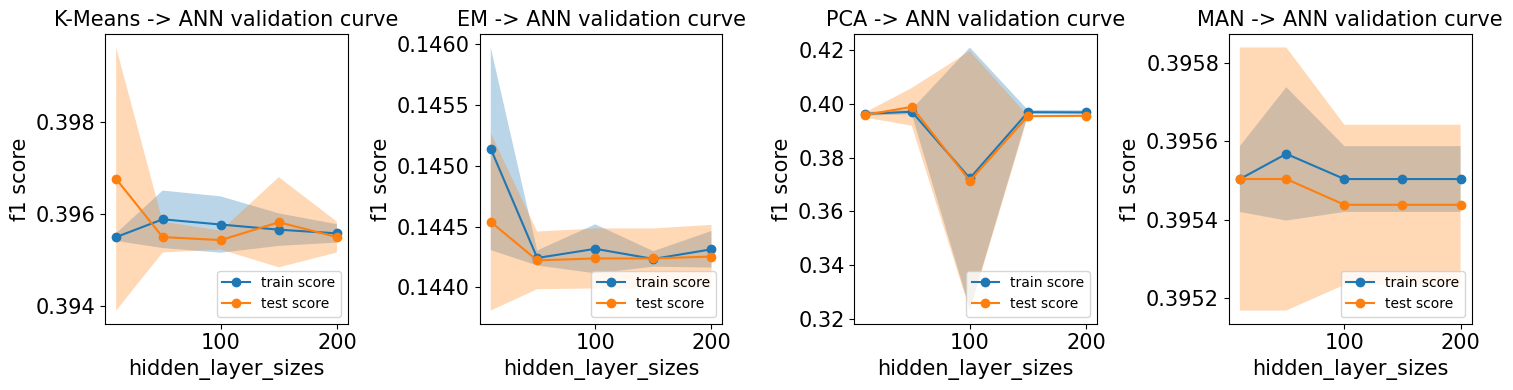

In [287]:
fig, axs = plt.subplots(1,4, figsize=(15, 4))
axs = axs.flatten()

plot_validation_curve(val_curve=nn_km_val_curve_shroom,\
                        x_range=[10,50,100,150,200],\
                        param_name='hidden_layer_sizes',
                        model_name='K-Means -> ANN', axs=axs[0]
                               )

plot_validation_curve(val_curve=nn_em_val_curve_shroom,\
                        x_range=[10,50,100,150,200],\
                        param_name='hidden_layer_sizes',
                        model_name='EM -> ANN', axs=axs[1]
                               )

plot_validation_curve(val_curve=nn_pca_val_curve_shroom,\
                        x_range=[10,50,100,150,200],\
                        param_name='hidden_layer_sizes',
                        model_name='PCA -> ANN', axs=axs[2]
                               )

plot_validation_curve(val_curve=nn_man_val_curve_shroom,\
                        x_range=[10,50,100,150,200],\
                        param_name='hidden_layer_sizes',
                        model_name='MAN -> ANN', axs=axs[3]
                               )
                               
plt.tight_layout()